### Import Packages 

In [1]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

# cartopy 
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature

### Step 1. Set up Dask for lazy/parallel computing 

In [14]:
from dask_gateway import Gateway
from dask.distributed import Client

# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=1, maximum=60)
# client = Client(cluster)
# cluster
gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)  # specify worker memory, max = 8
cluster.adapt(minimum=1, maximum=60)  # specify how many workers 
client = Client(cluster)
cluster

click on the above link to access the Dask dashboard

### Step 2. Load the MUR SST Dataset

2.1 Load the MUR SST dataset from AWS 

2.2 Load the MUR SST dataset from PODAAC thredds server 

2.3 Mask out erroneous data near poles 

In [13]:
# 2.1 load MUR SST dataset from AWS
%time 
AWS_url = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'
ds_sst = xr.open_zarr(AWS_url, consolidated=True)
ds_sst

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
# 2.2 load the MUR SST dataset from PODAAC thredds server 
PODAAC_url = ('https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc')
full_sst = xr.open_dataset(PODAAC_url)
full_sst

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 7120)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2021-11-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    license:                    These data are available free of charge under...
    id:                         MUR-JPL-L4-GLOB-v04.1
    naming_authority:           org.ghrsst
    product_version:            04.1
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20150703T211524Z
    start_time:                 20141109T090000Z
    stop_time:                  20141109T090000Z
    time_coverage_start:        20141108T210000Z
    time_coverage_end:          20141109T210000Z
    file_quality_level:         1
    source:                     AVHRR18_G-NAVO, AVHRR19_G-NAVO, AVHRR_METOP_A...
    platform:                   Aqua, DMSP, NOAA-POES, Suomi-NPP, Terra
    sensor:                     AMSR-E, AVHRR, MODIS, SSM/I, VIIRS, in-situ
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    spatial_resolution:         0.01 degrees
    geospatial_lat_units:       degrees north
    geospatial_lat_resolution:  0.01 degrees
    geospatial_lon_units:       degrees east
    geospatial_lon_resolution:  0.01 degrees
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               JPL MUR SST project
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_url:                http://mur.jpl.nasa.gov
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Note that the MUR SST dataset from AWS only has data available from 2002-Jan 2020, where as the dataset from PODAAC has data availble to present day (Nov. 2021). 

##### There are some erroneous SSTs near land at the poles so we will mask those out based on sea-ice fraction 

In [5]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction)) 
# don't fully understand the above step 

sst_masked = ds_sst['analysed_sst'].where(cond)

sst_masked

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,1276113 Tasks,141790 Chunks
Type,float32,numpy.ndarray


### Step 3. Create daily, monthly, yearly, and seasonal climatologies and anomalies 

#### let's create daily, monthly, yearly, and seasonal climatologies and anomalies 

In [6]:
%%time
#create a daily climatology and anomaly
climatology_mean = sst_masked.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = sst_masked.groupby('time.dayofyear')-climatology_mean  #take out annual mean to remove trends

#create a monthly dataset, climatology, and anomaly
sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

climatology_mean_monthly = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

sst_anomaly_monthly = sst_monthly.groupby('time.month')-climatology_mean_monthly  #take out annual mean to remove trends

# create a yearly dataset, climatology, and anomaly 

sst_yearly = sst_masked.resample(time='1Y').mean('time',keep_attrs=True,skipna=False)

climatology_mean_yearly = sst_yearly.groupby('time.year').mean('time',keep_attrs=True,skipna=False)

sst_anomaly_yearly = sst_yearly.groupby('time.year')-climatology_mean_yearly


CPU times: user 18.7 s, sys: 316 ms, total: 19 s
Wall time: 19 s


In [14]:
# is there a resample by season option???
sst_seasonal = sst_monthly.resample(time='quarter').mean('time',keep_attrs=True,skipna=False)

ValueError: Invalid frequency: quarter

In [7]:
seasonal_clima = sst_monthly.groupby('time.season').mean('time',keep_attrs=True,skipna=False)

In [8]:
seasonal_anom = sst_monthly.groupby('time.season')-seasonal_clima

### Step 4: Slice the dataset for desired regions (ATOMIC and LIS)

#### Let's slice the datasets for ATOMIC sampling area
##### Overall question: Has SST changed historically in the ATOMIC area. If so, how?

In [9]:
ATOMIC_sst = sst_masked.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_clima = climatology_mean.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_anom = sst_anomaly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_monthly = sst_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATMOIC_monthly_clima = climatology_mean_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_monthly_anom = sst_anomaly_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_yearly = sst_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_yearly_clima = climatology_mean_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_yearly_anom = sst_anomaly_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_seasonal = seasonal_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
ATOMIC_seasonal_anom = seasonal_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

#### make a subset of the area chosing a single lat/lon point to look at SST trends 

In [20]:
dailysubset = ATOMIC_sst.sel(lon=-55,lat=9).load()
monthlysubset = ATOMIC_monthly.sel(lon=-55,lat=9).load()

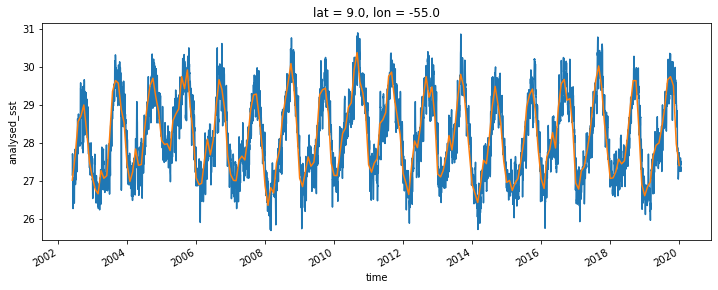

In [22]:
fig = plt.figure(figsize=(12,4))
dailysubset.plot()
monthlysubset.plot()

In [15]:
# Having issues running this through dask - gets close to the end then crashes 
anom_daily = ATOMIC_anom.sel(lon=-55, lat=9).load()

anom_monthly = ATOMIC_monthly_anom.sel(lon=-55, lat=9).load()

fig = plt.figure(figsize=(12,4))
anom_daily.plot()
anom_monthly.plot()

KeyboardInterrupt: 

#### spatially average ATOMIC area and look at trends 

In [10]:
daily_sst_spatial = ATOMIC_sst.mean(dim=('lon','lat')).load()

In [11]:
daily_anom_spatial = ATOMIC_anom.mean(dim=('lon','lat')).load()

In [15]:
ATOMIC_spatial_avg = ATOMIC_monthly.mean(dim=('lon','lat')).load()
ATOMIC_anom_spatial = ATOMIC_monthly_anom.mean(dim=('lon','lat')).load()

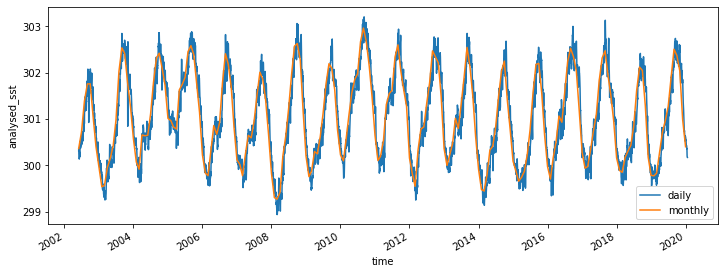

In [19]:
fig = plt.figure(figsize=(12,4))
daily_sst_spatial.plot(label='daily')
ATOMIC_spatial_avg.plot(label='monthly')
plt.legend()

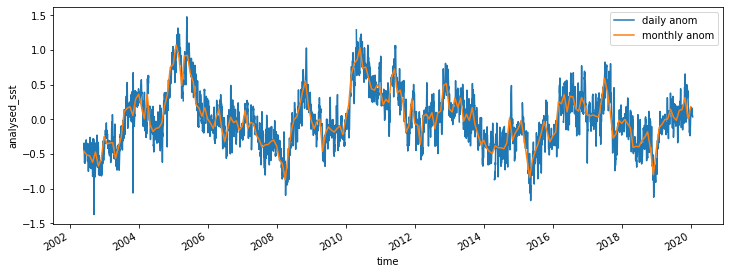

In [22]:
fig = plt.figure(figsize=(12,4))
daily_anom_spatial.plot(label='daily anom')
ATOMIC_anom_spatial.plot(label='monthly anom')
plt.legend()

### Seasonal Climatologies 

In [11]:
ATOMIC_seasonal.load()

<xarray.DataArray 'analysed_sst' (season: 4, lat: 1001, lon: 1401)>
array([[[      nan,       nan,       nan, ..., 300.5915 , 300.59262,
         300.59406],
        [      nan,       nan,       nan, ..., 300.5906 , 300.59183,
         300.59323],
        [      nan,       nan,       nan, ..., 300.5901 , 300.59143,
         300.59274],
        ...,
        [300.50214, 300.50278, 300.50336, ..., 299.52094, 299.52005,
         299.51932],
        [300.5022 , 300.50287, 300.50354, ..., 299.51904, 299.51782,
         299.51697],
        [300.5025 , 300.50305, 300.5037 , ..., 299.51724, 299.51566,
         299.5147 ]],

       [[      nan,       nan,       nan, ..., 301.3552 , 301.35596,
         301.35648],
        [      nan,       nan,       nan, ..., 301.3579 , 301.3586 ,
         301.35922],
        [      nan,       nan,       nan, ..., 301.36072, 301.36136,
         301.36197],
...
        [300.50763, 300.5068 , 300.50613, ..., 299.05472, 299.0542 ,
         299.05353],
        [300.5089 , 300.50766, 300.5065 , ..., 299.05246, 299.05188,
         299.05118],
        [300.50964, 300.50803, 300.50656, ..., 299.05057, 299.04996,
         299.04907]],

       [[      nan,       nan,       nan, ..., 301.14084, 301.14096,
         301.14084],
        [      nan,       nan,       nan, ..., 301.14566, 301.14566,
         301.14563],
        [      nan,       nan,       nan, ..., 301.1504 , 301.15057,
         301.1508 ],
        ...,
        [302.3543 , 302.35175, 302.34924, ..., 301.26624, 301.26703,
         301.26782],
        [302.3534 , 302.35065, 302.34796, ..., 301.26523, 301.26617,
         301.26715],
        [302.35272, 302.35004, 302.34732, ..., 301.26364, 301.26477,
         301.26584]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.0 4.01 4.02 4.03 4.04 ... 13.97 13.98 13.99 14.0
  * lon      (lon) float32 -62.0 -61.99 -61.98 -61.97 ... -48.02 -48.01 -48.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

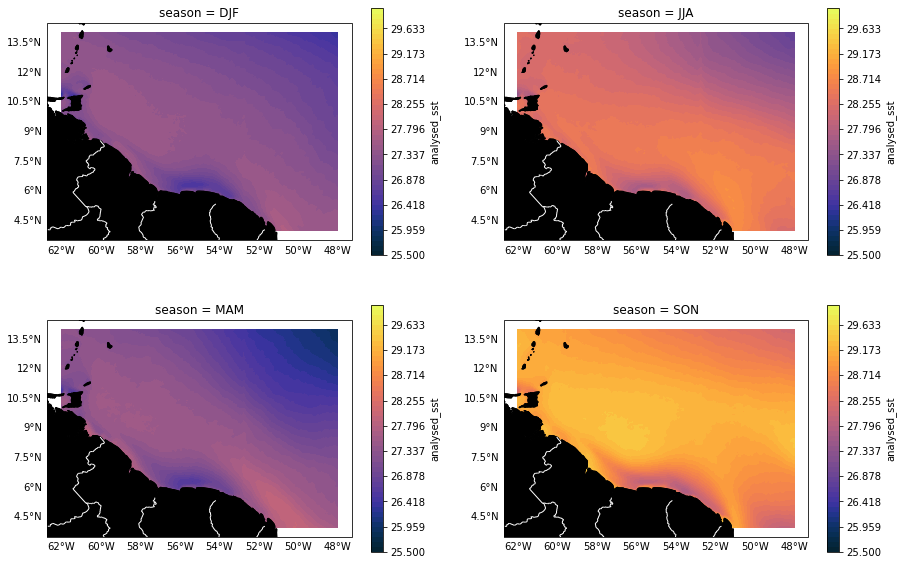

In [13]:
# Seasonal plots using cartopy 

kw = {'vmin':25.5,'vmax':30,'levels':50,'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

ATOMIC_seasonal.isel(season=0).plot(ax=axs[0],**kw,zorder=0)
ATOMIC_seasonal.isel(season=1).plot(ax=axs[1],**kw,zorder=0)
ATOMIC_seasonal.isel(season=2).plot(ax=axs[2],**kw,zorder=0)
ATOMIC_seasonal.isel(season=3).plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

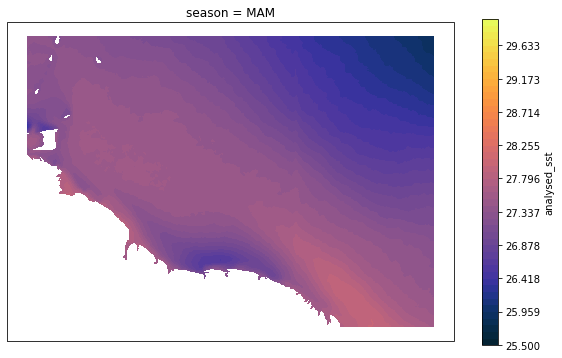

In [29]:
kw = {'vmin':25.5,'vmax':30,'levels':50,'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ATOMIC_seasonal.isel(season=2).plot(**kw,zorder=0)

In [9]:
ATOMIC_monthly.load();

In [10]:
ATOMIC_spatial_avg = ATOMIC_monthly.mean(dim=('lon','lat'))
ATOMIC_anom_spatial = ATOMIC_monthly_anom.mean(dim=('lon','lat'))

In [11]:
ATOMIC_anom_spatial.load()

<xarray.DataArray 'analysed_sst' (time: 212)>
array([-4.60408032e-01, -5.14562547e-01, -5.25589764e-01, -6.19940519e-01,
       -4.70339447e-01, -6.74327791e-01, -5.74373245e-01, -2.47567832e-01,
       -3.53142560e-01, -3.42427164e-01, -3.36266845e-01, -5.64132988e-01,
       -4.03830528e-01, -2.56319851e-01,  1.08508870e-01,  1.58297971e-01,
        1.81903750e-01,  5.50234057e-02,  2.92016029e-01,  3.61562878e-01,
        1.80448249e-01,  7.95437768e-03,  3.62376869e-01, -7.19571635e-02,
       -1.75765321e-01, -1.30871490e-01, -1.21970102e-01, -5.84367737e-02,
        1.90442234e-01,  3.62897456e-01,  7.48324573e-01,  7.92485356e-01,
        1.07247972e+00,  9.16691184e-01,  4.90883768e-01,  9.16734934e-01,
        9.21607256e-01,  6.61337435e-01,  5.36542177e-01,  2.04557702e-01,
        1.61398590e-01,  4.41032015e-02,  1.67128235e-01,  9.83288046e-04,
       -5.75852878e-02, -1.31490186e-01,  3.12978886e-02,  1.48348346e-01,
       -1.54586256e-01, -3.21621150e-01, -1.35834411e-01,  3.09565328e-02,
       -4.69129756e-02, -2.21524667e-02, -1.56625614e-01, -1.00655630e-01,
        1.27837926e-01, -1.31932110e-01, -4.34811041e-02, -6.23614639e-02,
       -2.30022058e-01, -2.97138959e-01, -4.04640049e-01, -3.67661953e-01,
       -3.64017576e-01, -3.20453823e-01, -2.99868733e-01, -3.84813666e-01,
       -5.86958051e-01, -6.39123440e-01, -8.74082685e-01, -5.08864343e-01,
       -1.87673315e-01, -1.06316227e-02,  4.06080484e-02,  1.94790080e-01,
        3.99245262e-01,  5.52697897e-01,  2.00202018e-01, -1.92598086e-02,
...
       -8.11722800e-02, -2.21054196e-01, -3.58199567e-01, -3.02033275e-01,
       -4.14288759e-01, -4.62883443e-01, -4.93161261e-01, -3.81187379e-01,
       -4.09359664e-01, -4.10570294e-01, -4.24804777e-01, -3.44536930e-01,
        2.01837812e-02, -3.06427121e-01, -1.94102019e-01, -1.29606143e-01,
       -1.78909060e-02, -2.51091719e-01, -5.50424159e-01, -8.37549210e-01,
       -5.82396269e-01, -4.58069384e-01, -3.45783383e-01, -1.98167190e-01,
       -3.02754436e-02, -1.71692520e-01, -3.24798465e-01, -2.43073016e-01,
       -1.87092692e-01,  2.53494442e-01,  2.23578528e-01,  3.53718281e-01,
        1.07789941e-01,  3.32679987e-01,  3.23870271e-01,  1.50574833e-01,
        1.18160546e-01,  3.13142508e-01,  2.16450363e-01,  6.35459870e-02,
        4.86022718e-02,  6.28038049e-02,  4.38995324e-02,  3.23826857e-02,
        2.83292830e-01,  5.92088997e-01,  4.00499135e-01,  9.35319811e-02,
       -2.71253854e-01, -2.07745701e-01, -1.48735046e-02, -5.85511997e-02,
       -1.78152858e-03, -5.87408170e-02, -1.22244701e-01, -4.05150950e-01,
       -3.89190167e-01, -3.95399898e-01, -3.04242849e-01, -2.56546646e-01,
       -1.82308838e-01, -4.36545223e-01, -8.00766885e-01, -4.35049951e-01,
       -1.16714053e-01, -7.51369521e-02, -3.50754545e-03,  3.71473166e-03,
        1.45812482e-01,  3.22173424e-02, -1.44917713e-02,  1.27894804e-01,
        1.41018808e-01,  3.12468410e-01,  9.28995851e-03,  1.80882469e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 2002-07-01 ... 2020-01-01
    month    (time) int64 6 7 8 9 10 11 12 1 2 3 4 ... 3 4 5 6 7 8 9 10 11 12 1

In [12]:
ATOMIC_spatial_avg.load()

<xarray.DataArray 'analysed_sst' (time: 212)>
array([300.36514, 300.7247 , 301.3905 , 301.75876, 301.76068, 301.05096,
       300.40802, 299.97516, 299.54083, 299.5691 , 299.95828, 300.1487 ,
       300.42175, 300.98294, 302.0246 , 302.53702, 302.41284, 301.7803 ,
       301.27438, 300.58417, 300.0744 , 299.91962, 300.6569 , 300.64093,
       300.6498 , 301.10828, 301.7942 , 302.32025, 302.4214 , 302.08807,
       301.7306 , 301.0152 , 300.96646, 300.82828, 300.78543, 301.62955,
       301.7471 , 301.90054, 302.4528 , 302.5832 , 302.39236, 301.7693 ,
       301.14948, 300.2236 , 299.83646, 299.7801 , 300.32584, 300.86115,
       300.671  , 300.9177 , 301.7802 , 302.4096 , 302.18402, 301.7032 ,
       300.82562, 300.12192, 300.02188, 299.77975, 300.25113, 300.65033,
       300.59555, 300.94205, 301.51154, 302.01093, 301.86694, 301.40482,
       300.68243, 299.8379 , 299.3071 , 299.2725 , 299.42047, 300.20386,
       300.6379 , 301.2286 , 301.95682, 302.57346, 302.63034, 302.2779 ,
       301.18253, 300.20337, 299.75903, 299.87863, 300.2997 , 300.25165,
       300.62476, 301.1296 , 301.76138, 302.19458, 302.097  , 301.62888,
       300.76   , 300.22778, 300.10043, 300.55905, 301.10013, 301.5696 ,
       301.8571 , 301.97693, 302.66937, 302.96393, 302.67007, 302.14487,
       301.48215, 300.6542 , 300.1047 , 300.2    , 300.53983, 301.31406,
       301.55002, 301.62076, 302.33722, 302.60135, 302.04376, 301.63446,
       301.27716, 300.1602 , 299.812  , 299.5514 , 300.33844, 300.78702,
       300.8327 , 301.33423, 301.78177, 302.4713 , 302.34686,       nan,
       301.5001 , 300.36957, 300.00003, 300.22055, 300.4658 , 301.0176 ,
       300.79807, 301.31137, 301.89807, 302.54706, 302.14978, 301.50412,
       300.62415, 299.92062, 299.47964, 299.44867, 299.8013 , 300.33154,
       300.41617, 300.82867, 301.4913 , 302.03403, 302.2512 , 301.41888,
       300.78824, 300.09305, 299.87607, 299.66043, 299.74405, 299.87518,
       300.24304, 300.7812 , 301.57037, 302.18045, 302.20078, 301.5536 ,
       300.65744, 299.9795 , 299.70694, 300.16504, 300.51813, 301.06644,
       300.93344, 301.57184, 302.24008, 302.52924, 302.34927, 302.03836,
       301.19867, 300.28613, 299.9426 , 299.97443, 300.3385 , 300.74518,
       301.1088 , 301.83145, 302.31665, 302.47223, 301.95978, 301.51746,
       300.96747, 300.1641 , 299.89233, 299.85278, 300.17233, 300.30762,
       300.4364 , 300.84375, 301.61194, 302.12207, 302.0487 , 301.2886 ,
       300.18158, 299.7876 , 299.77725, 299.83652, 300.29114, 300.71658,
       300.97144, 301.27155, 301.90167, 302.50662, 302.37198, 302.0377 ,
       300.99158, 300.40353], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 2002-07-01 ... 2020-01-01

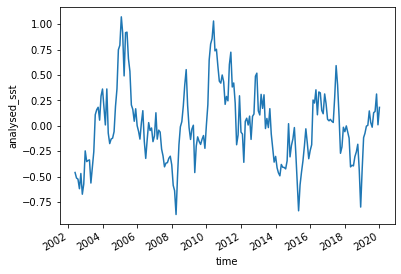

In [13]:
# ATOMIC_spatial_avg.plot()
ATOMIC_anom_spatial.plot()

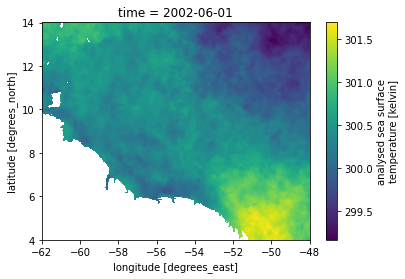

In [14]:

ATOMIC_monthly[0].plot()

### global stuff - work on this later 

In [14]:
test = sst_anomaly_monthly.mean(dim=('lon','lat'))

In [17]:
test

<xarray.DataArray 'analysed_sst' (time: 212)>
dask.array<mean_agg-aggregate, shape=(212,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 2002-07-01 ... 2020-01-01
    month    (time) int64 6 7 8 9 10 11 12 1 2 3 4 ... 3 4 5 6 7 8 9 10 11 12 1

In [ ]:
test.load()

In [7]:
# calculate global SST trends 

# daily trends 
global_sst_d = sst_masked.mean(dim=('lat','lon'))

# monthly 
global_sst_m = sst_monthly.mean(dim=('lat','lon'))

#yearly
global_sst_y = sst_yearly.mean(dim=('lat','lon'))

In [8]:
global_sst_m

<xarray.DataArray 'analysed_sst' (time: 212)>
dask.array<mean_agg-aggregate, shape=(212,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 2002-07-01 ... 2020-01-01

In [ ]:
global_sst_y.load()